In [1]:
import sys
sys.path.append("..")
# Load in MNIST
import torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.datasets as datasets

# *** I need to actually do something more sophisicated with normalization to ensure that these
# inputs are normalized in the same waya as the ones we trained on, but Torch seems
# a bit complicated to me on this front so I am ignoring it for now :) 

device = torch.device("cpu")
mnist_trainset = datasets.MNIST(root='./Datasets', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./Datasets', train=False, download=True, transform=None)

import GradCertModule
import pytorch_lightning as pl
from pl_examples.basic_examples.mnist_datamodule import MNISTDataModule

import random
import numpy as np
SEED = 0
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Model Options

ALPHA = 1.0            # Regularization Parameter (Weights the Reg. Term)
EPSILON = 0.0          # Input Peturbation Budget at Training Time
GAMMA = 0.00            # Model Peturbation Budget at Training Time 
                        #(Changed to proportional budget rather than absolute)
    
LEARN_RATE = 0.001     # Learning Rate Hyperparameter
HIDDEN_DIM = 128       # Hidden Neurons Hyperparameter
HIDDEN_LAY = 1         # Hidden Layers Hyperparameter
MAX_EPOCHS = 15
BATCH_SIZE = 100

EPSILON_LINEAR = True   # Put Epsilon on a Linear Schedule?
GAMMA_LINEAR = True     # Put Gamma on a Linear Schedule?

In [2]:
import XAIArchitectures
model = XAIArchitectures.DeepMindSmall()
model.set_params(alpha=ALPHA, epsilon=EPSILON, gamma=GAMMA,
                learn_rate=LEARN_RATE, max_epochs=MAX_EPOCHS,
                epsilon_linear=EPSILON_LINEAR,gamma_linear=GAMMA_LINEAR,
                mode="GRAD")
    
    

SCHEDULED = EPSILON_LINEAR or GAMMA_LINEAR 
#DeepMindSmall_e=0.0_g=0.0_a=0.0_s=True.ckpt
MODEL_ID = "DeepMindSmall_e=%s_g=%s_a=%s_s=%s"%(EPSILON, GAMMA, ALPHA, SCHEDULED)
#MODEL_ID = "DeepMindSmall_e=%s_g=%s_h=%s_l=%s_a=%s_s=%s"%(EPSILON, GAMMA, HIDDEN_DIM, HIDDEN_LAY, ALPHA, SCHEDULED)   
ckpt = torch.load("SEED_Models/%s.ckpt"%(MODEL_ID))

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
checkpoint = torch.load("SEED_Models/%s.ckpt"%(MODEL_ID))
for key in checkpoint:
    print(key)
model.load_state_dict(torch.load('SEED_Models/%s.pt'%(MODEL_ID)))



epoch
global_step
pytorch-lightning_version
state_dict
callbacks
optimizer_states
lr_schedulers
hparams_name
hyper_parameters


<All keys matched successfully>

In [3]:
def gen_model_id(EPSILON=0.0, GAMMA=0.0, alpha=0.1):
    #if(EPSILON == 0.0):
    #    ALPHA = 1.0
    #    GAMMA = 0.0
    #else:
    #    ALPHA = 0.5            # Regularization Parameter (Weights the Reg. Term)
    #    GAMMA = 0.01
    ALPHA = alpha
    GAMMA = 0.0
    LEARN_RATE = 0.0005     # Learning Rate Hyperparameter
    HIDDEN_DIM = 256       # Hidden Neurons Hyperparameter
    HIDDEN_LAY = 2         # Hidden Layers Hyperparameter
    MAX_EPOCHS = 25

    EPSILON_LINEAR = True   # Put Epsilon on a Linear Schedule?
    GAMMA_LINEAR = True     # Put Gamma on a Linear Schedule?
    
    MODEL_ID = "DeepMindSmall_e=%s_g=%s_a=%s_s=%s"%(EPSILON, GAMMA, ALPHA, SCHEDULED)
    print(MODEL_ID)
    return MODEL_ID

gen_model_id(0, 0)

DeepMindSmall_e=0_g=0.0_a=0.1_s=True


'DeepMindSmall_e=0_g=0.0_a=0.1_s=True'

In [4]:
# Get Input Certification

def get_accuracy(eps_t, eps, n=100):
    M_ID = gen_model_id(eps_t, 0.0)
    model.load_state_dict(torch.load('SEED_Models/%s.pt'%(M_ID)))
    certified = 0
    for i in range(n):
        data = np.asarray(mnist_testset[i][0])/255.0
        data = torch.Tensor([data])
        target = torch.Tensor([mnist_testset[i][1]]).type(torch.LongTensor)
        #y_l = adv_attack(model, data, target, eps)
        #y_l, y_u = GradCertModule.RobustnessBounds(model, data, target, eps=eps, gam=0.0)
        y = model(data)
        if(np.argmax(y.detach().numpy()) == mnist_testset[i][1]):
            certified += 1
    return certified/n


#e_test_vals = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
eps_vals = [0.0, 0.01, 0.025, 0.05, 0.1]

acc_rates = []
for e_t in eps_vals:
    acc = get_accuracy(e_t, 0.0, n=100)
    acc_rates.append(acc)


DeepMindSmall_e=0.0_g=0.0_a=0.1_s=True


/Users/matthewwicker/opt/anaconda3/envs/XAIenvironment/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1659484744261/work/torch/csrc/utils/tensor_new.cpp:204.)
  if __name__ == "__main__":


DeepMindSmall_e=0.01_g=0.0_a=0.1_s=True
DeepMindSmall_e=0.025_g=0.0_a=0.1_s=True
DeepMindSmall_e=0.05_g=0.0_a=0.1_s=True
DeepMindSmall_e=0.1_g=0.0_a=0.1_s=True


In [5]:
print(acc_rates)

[0.99, 0.96, 0.92, 0.9, 0.6]


In [6]:
# Get Input Attack
GLOBAL_TARGEX = None
from GradCertModule import run_mnist_attack
def compute_fooling_rate(model, eps_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], forward=True, n=50):
    fool_i, fool_j = 4, 4
    success = [int(10) for i in range(n)]
    if(not forward):
        eps_test = list(reversed(eps_test))
    for eps in eps_test:
        print("******** COMPUTING FOR EPS = %s *********"%(eps))
        for i in range(n):
            if(success[i] != 10):
                continue
            data = np.asarray(mnist_testset[i][0])/255.0
            data = torch.Tensor([data])
            b_val, x_adv, grad_adv, targex, loss = run_mnist_attack(model, data, target = [5, 5], 
                                                            epsilon=eps, iterations=75, lr=eps/50)
            GLOBAL_TARGEX = targex
            
            #plt.imshow(grad_adv.detach().numpy().reshape(28,28), cmap='coolwarm')
            #plt.show()
            if(loss <= 0.04 and forward): # Heuristic Threshold for Fooling Rate
                success[i] = eps
            elif(loss > 0.04 and not forward):
                success[i] = eps
            print(loss, i)
            #grad_advs.append(grad_adv)

    fooling_rate = []
    for v in eps_test:
        val = sum(i <= v for i in success)
        fooling_rate.append(val/len(success))
    return fooling_rate

In [7]:
#fooling_rates = compute_fooling_rate(model, [0.1], n=1)

data = np.asarray(mnist_testset[0][0])/255.0
data = torch.Tensor([data])
b_val, x_adv, grad_adv, targex, loss = run_mnist_attack(model, data, target = [5, 5], 
                                                epsilon=0.1, iterations=75, lr=0.1/50)

GLOBAL_TARGEX = targex

Loss: 0.04079950228333473: 100%|████████████████████████████████████████████████| 75/75 [00:02<00:00, 25.42it/s]


In [8]:
"""
rates_FULL = []
for eps in [0.0, 0.01, 0.025, 0.05]:
    M_ID = gen_model_id(eps, 0.0)
    model.load_state_dict(torch.load('SEED_Models/%s.pt'%(M_ID)))
    if(eps == 0.0):
        fooling_rates = compute_fooling_rate(model, forward=True)
    else: 
        fooling_rates = compute_fooling_rate(model, forward=False)
    rates_FULL.append(fooling_rates)
"""


"\nrates_FULL = []\nfor eps in [0.0, 0.01, 0.025, 0.05]:\n    M_ID = gen_model_id(eps, 0.0)\n    model.load_state_dict(torch.load('SEED_Models/%s.pt'%(M_ID)))\n    if(eps == 0.0):\n        fooling_rates = compute_fooling_rate(model, forward=True)\n    else: \n        fooling_rates = compute_fooling_rate(model, forward=False)\n    rates_FULL.append(fooling_rates)\n"

In [9]:
#print(rates_FULL)


computed_rates =  [[0.14, 0.78, 0.96, 0.96, 0.96, 0.96, 0.96, 0.96], 
                   [0.0, 0.1, 0.12, 0.14, 0.2, 0.26, 0.26, 0.28], 
                   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
                   [0.02, 0.02, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]



['#2d1e3e', '#613969', '#945785', '#bd7a98', '#daa4ac', '#edd1cb']


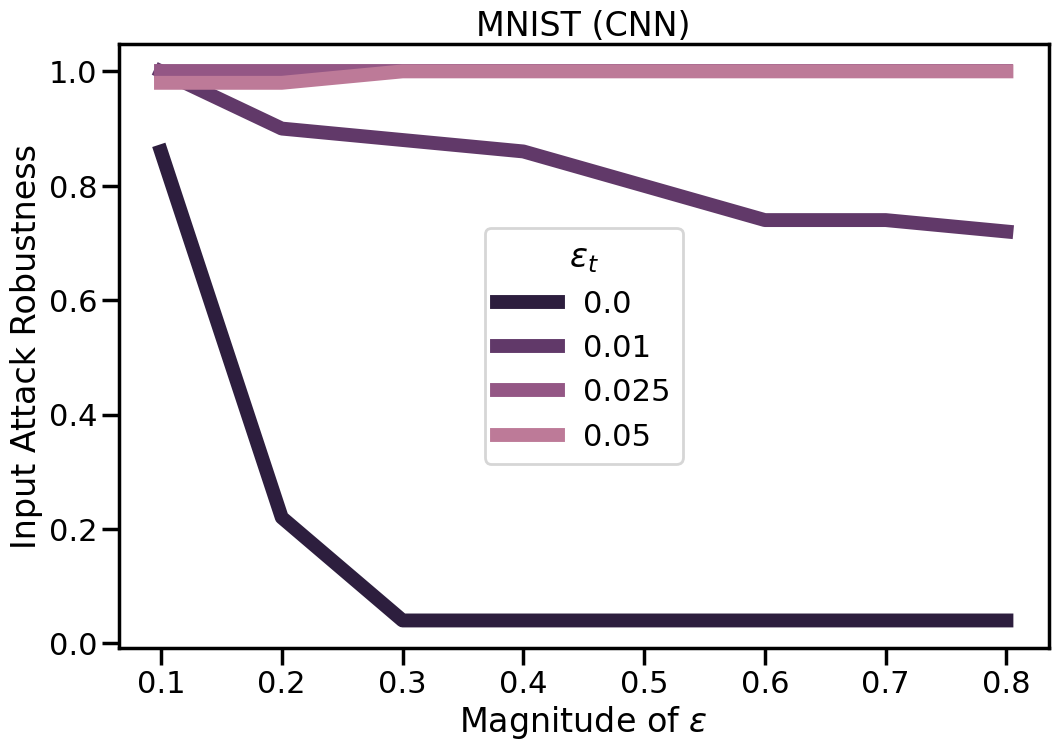

In [10]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('darkgrid')
sns.set_context('poster')
plt.figure(figsize=(12, 8), dpi=100)

dataset = "MNIST"
    
pal = sns.cubehelix_palette()
pal = pal.as_hex()
pal = [i for i in reversed(pal)]
print(pal)
#print(pal.as_hex())

e_test_vals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

eps_vals = [0.0, 0.01, 0.025, 0.05]
for i in range(len(eps_vals)):
    plt.plot(1-np.asarray(computed_rates[i]), label=eps_vals[i], 
             color=pal[i], linewidth=10)
plt.legend()
ax = plt.gca()

ax.set_xticks(range(len(e_test_vals)))
ax.set_xticklabels(e_test_vals)

plt.title("%s (CNN)"%(dataset))
plt.ylabel("Input Attack Robustness")
plt.xlabel(r"Magnitude of $\epsilon$")
ax.get_legend().set_title(r"$\epsilon_t$")

plt.show()

In [11]:
from torch.nn import functional as F

def certify_model(model, data, target, eps=0.1):
    
    min_grad, max_grad = GradCertModule.GradCertBounds(model, data, target, eps, 0)
    min_grad, max_grad = min_grad.detach().numpy().reshape(28,28), max_grad.detach().numpy().reshape(28,28)
    
    #print(min_grad, max_grad)
    
    y_l, y_u = GradCertModule.RobustnessBounds(model, data, target, eps=eps, gam=0.0)
    
    data = data.detach().numpy().reshape(28,28)
    data = torch.Tensor(data)
    
    targets = [[4,4], [5,5], [6,6], [7,7], [24,4], [23,5], [22,6], [21,7],
              [4,24], [5,23], [6,22], [7,21], [24,24], [23,23], [22,22], [21,21]]
    lowest_loss = 1000000000000000
    for t in targets:
        targ_i, targ_j = t
        targex = np.asarray(min_grad) * 0.0
        targex[targ_i-4:targ_i+4,targ_j-4:targ_j+4] = 1
        v_cert = 0.0*targex
        v_cert += np.where(targex > max_grad, max_grad, 0) # if targex is larger than max, take the max
        v_cert += np.where(targex < min_grad, min_grad, 0) # if targex is less than min take, min
        inds = np.where((targex <= max_grad) & (targex >= min_grad)) # if targex is between take targex
        v_cert[inds] = targex[inds]
        #print(type(v_cert), type(targex))
        loss_expl = F.mse_loss(torch.Tensor(v_cert), torch.Tensor(targex))
        if(loss_expl < lowest_loss):
            lowest_loss = loss_expl
    #loss_expl = F.mse_loss(closest_exp, targex)
    #loss_output = F.mse_loss(torch.nn.functional.one_hot(target, num_classes=10), y_u.detach())
    total_loss = lowest_loss 
        
    return total_loss


def get_cert_rate(eps_t, eps, n=100):
    M_ID = gen_model_id(eps_t, 0.0)
    model.load_state_dict(torch.load('SEED_Models/%s.pt'%(M_ID)))
    certified = 0
    all_values = []
    for i in range(n):
        data = np.asarray(mnist_testset[i][0])/255.0
        data = torch.Tensor([data])
        target = torch.Tensor([mnist_testset[i][1]]).type(torch.LongTensor)
        val = certify_model(model, data, target, eps=eps)
        #print(val)
        all_values.append(round(float(val.detach().numpy()),3))
        #all_values.append(round(val, 3))
        if(val > 0.04):
            certified += 1   
    return certified/n #, all_values



In [12]:
e_test_vals = [0.00, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175]
eps_vals = [0.0, 0.01, 0.025, 0.05, 0.1]

cert_rates = []
for e_t in eps_vals:
    result = []
    for e in e_test_vals:
        val = get_cert_rate(e_t, e, n=200)
        result.append(val)
    cert_rates.append(result)


DeepMindSmall_e=0.0_g=0.0_a=0.1_s=True


../GradCertModule.py:282: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1659484744261/work/aten/src/ATen/native/TensorShape.cpp:2985.)
  return dL_min.T, dL_max.T #dL_dz_min.T, dL_dz_max.T


DeepMindSmall_e=0.0_g=0.0_a=0.1_s=True
DeepMindSmall_e=0.0_g=0.0_a=0.1_s=True
DeepMindSmall_e=0.0_g=0.0_a=0.1_s=True
DeepMindSmall_e=0.0_g=0.0_a=0.1_s=True
DeepMindSmall_e=0.0_g=0.0_a=0.1_s=True
DeepMindSmall_e=0.0_g=0.0_a=0.1_s=True
DeepMindSmall_e=0.0_g=0.0_a=0.1_s=True
DeepMindSmall_e=0.01_g=0.0_a=0.1_s=True
DeepMindSmall_e=0.01_g=0.0_a=0.1_s=True
DeepMindSmall_e=0.01_g=0.0_a=0.1_s=True
DeepMindSmall_e=0.01_g=0.0_a=0.1_s=True
DeepMindSmall_e=0.01_g=0.0_a=0.1_s=True
DeepMindSmall_e=0.01_g=0.0_a=0.1_s=True
DeepMindSmall_e=0.01_g=0.0_a=0.1_s=True
DeepMindSmall_e=0.01_g=0.0_a=0.1_s=True
DeepMindSmall_e=0.025_g=0.0_a=0.1_s=True
DeepMindSmall_e=0.025_g=0.0_a=0.1_s=True
DeepMindSmall_e=0.025_g=0.0_a=0.1_s=True
DeepMindSmall_e=0.025_g=0.0_a=0.1_s=True
DeepMindSmall_e=0.025_g=0.0_a=0.1_s=True
DeepMindSmall_e=0.025_g=0.0_a=0.1_s=True
DeepMindSmall_e=0.025_g=0.0_a=0.1_s=True
DeepMindSmall_e=0.025_g=0.0_a=0.1_s=True
DeepMindSmall_e=0.05_g=0.0_a=0.1_s=True
DeepMindSmall_e=0.05_g=0.0_a=0.1_s=True

In [13]:
print(cert_rates)

[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.81, 0.055, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.955, 0.515, 0.11, 0.005, 0.0, 0.0, 0.0], [1.0, 1.0, 0.965, 0.775, 0.35, 0.095, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.97, 0.91]]


In [14]:
cert_rates = [[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
              [1.0, 0.81, 0.055, 0.0, 0.0, 0.0, 0.0, 0.0],
              [1.0, 0.955, 0.515, 0.11, 0.005, 0.0, 0.0, 0.0], 
              [1.0, 1.0, 0.965, 0.775, 0.35, 0.095, 0.0, 0.0], 
              [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.97, 0.91]]


[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.81, 0.055, 0.0, 0.0, 0.0, 0.0, 0.0], [1.0, 0.955, 0.515, 0.11, 0.005, 0.0, 0.0, 0.0], [1.0, 1.0, 0.965, 0.775, 0.35, 0.095, 0.0, 0.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.97, 0.91]]
['#d7dfc0', '#9bc799', '#65a88e', '#477d89', '#3b4a71', '#2c1e3e']


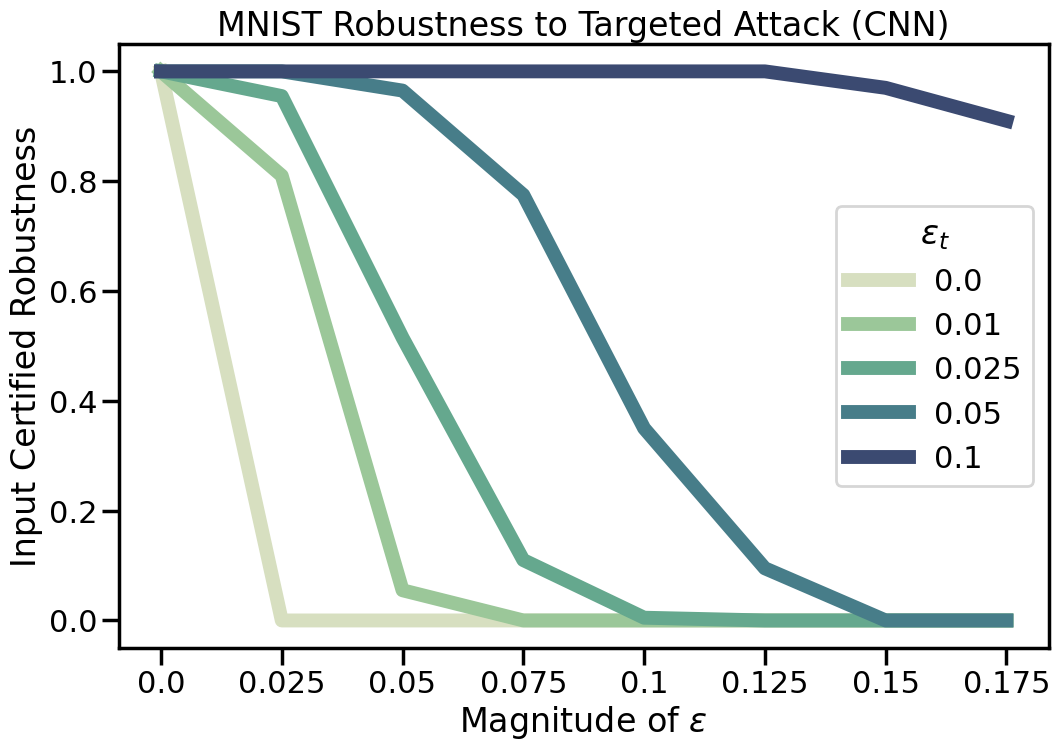

In [15]:
print(cert_rates)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('darkgrid')
sns.set_context('poster')
plt.figure(figsize=(12, 8), dpi=100)

pal = sns.cubehelix_palette(start=.5, rot=-.75)
print(pal.as_hex())

for i in range(len(eps_vals)):
    plt.plot(cert_rates[i], label=eps_vals[i], 
             color=pal[i], linewidth=10)
plt.legend()
ax = plt.gca()
ax.set_xticks(range(len(e_test_vals)))
ax.set_xticklabels(e_test_vals)
plt.title("%s Robustness to Targeted Attack (CNN)"%(dataset))
plt.ylabel("Input Certified Robustness")
plt.xlabel(r"Magnitude of $\epsilon$")
ax.get_legend().set_title(r"$\epsilon_t$")
plt.show()

In [17]:
def get_untargeted_delta(eps_t, eps, n=100):
    M_ID = gen_model_id(eps_t, 0.0, alpha=0.1)
    model.load_state_dict(torch.load('SEED_Models/%s.pt'%(M_ID)))
    delta_avg = 0
    all_values = []
    for i in range(n):
        data = np.asarray(mnist_testset[i][0])/255.0
        data = torch.Tensor([data])
        target = torch.Tensor([mnist_testset[i][1]]).type(torch.LongTensor)
        min_grad, max_grad = GradCertModule.GradCertBounds(model, data, target, eps, 0)
        min_grad, max_grad = min_grad.detach().numpy(), max_grad.detach().numpy() 
        delta_cert = np.abs(max_grad - min_grad)
        grad = GradCertModule.InputGrad(model, data, target)
        grad = np.abs((grad.detach().numpy())) + 1e-10 # Deals with zero grad diff issues
        #print(np.squeeze(grad) - np.squeeze(delta_cert))
        #print("************")
        #print(np.squeeze(delta_cert)/np.squeeze(grad))
        #print("************")
        #print(np.mean(np.squeeze(delta_cert)/np.squeeze(grad)))
        #denom = np.abs(max_grad + min_grad/2)
        #print(np.mean(delta_cert), np.mean(grad), np.mean(delta_cert/grad))
        #delta_avg += np.mean(np.squeeze(delta_cert)/np.squeeze(grad))
        delta_avg += np.mean(delta_cert)/np.mean(grad)
    print(delta_avg/n)
    return delta_avg/n


e_test_vals = [0.005, 0.01, 0.025, 0.05, 0.075]
eps_vals = [0.0, 0.01, 0.025, 0.05, 0.1]
delta_vals = []
for e_t in eps_vals:
    result = []
    for e in e_test_vals:
        val = get_untargeted_delta(e_t, e, n=100)
        result.append(val)
        #break
    #break
    delta_vals.append(result)

DeepMindSmall_e=0.0_g=0.0_a=0.1_s=True
368.11089347839356
DeepMindSmall_e=0.0_g=0.0_a=0.1_s=True
1196.2783154296876
DeepMindSmall_e=0.0_g=0.0_a=0.1_s=True
4752.876481933594
DeepMindSmall_e=0.0_g=0.0_a=0.1_s=True
12845.158295898438
DeepMindSmall_e=0.0_g=0.0_a=0.1_s=True
22360.375224609375
DeepMindSmall_e=0.01_g=0.0_a=0.1_s=True
0.5169661354273558
DeepMindSmall_e=0.01_g=0.0_a=0.1_s=True
1.0639938501268624
DeepMindSmall_e=0.01_g=0.0_a=0.1_s=True
5.208479527831077
DeepMindSmall_e=0.01_g=0.0_a=0.1_s=True
211.98161937236785
DeepMindSmall_e=0.01_g=0.0_a=0.1_s=True
27536.24883136749
DeepMindSmall_e=0.025_g=0.0_a=0.1_s=True
0.8490790600702166
DeepMindSmall_e=0.025_g=0.0_a=0.1_s=True
2.0155820133537055
DeepMindSmall_e=0.025_g=0.0_a=0.1_s=True
6.71381725102663
DeepMindSmall_e=0.025_g=0.0_a=0.1_s=True
112.560665923357
DeepMindSmall_e=0.025_g=0.0_a=0.1_s=True
30937.621943755148
DeepMindSmall_e=0.05_g=0.0_a=0.1_s=True
1.1530004742369055
DeepMindSmall_e=0.05_g=0.0_a=0.1_s=True
2.3812309701740744
Deep

[[368.11089347839356, 1196.2783154296876, 4752.876481933594, 12845.158295898438, 22360.375224609375], [0.5169661354273558, 1.0639938501268624, 5.208479527831077, 211.98161937236785, 27536.24883136749], [0.8490790600702166, 2.0155820133537055, 6.71381725102663, 112.560665923357, 30937.621943755148], [1.1530004742369055, 2.3812309701740744, 6.735682218819857, 39.17857146203518, 161.53651880323886], [0.6009112701565027, 1.184331625364721, 3.2288978011906146, 7.46307270437479, 11.61409501761198]]
['#d7dfc0', '#9bc799', '#65a88e', '#477d89', '#3b4a71', '#2c1e3e']


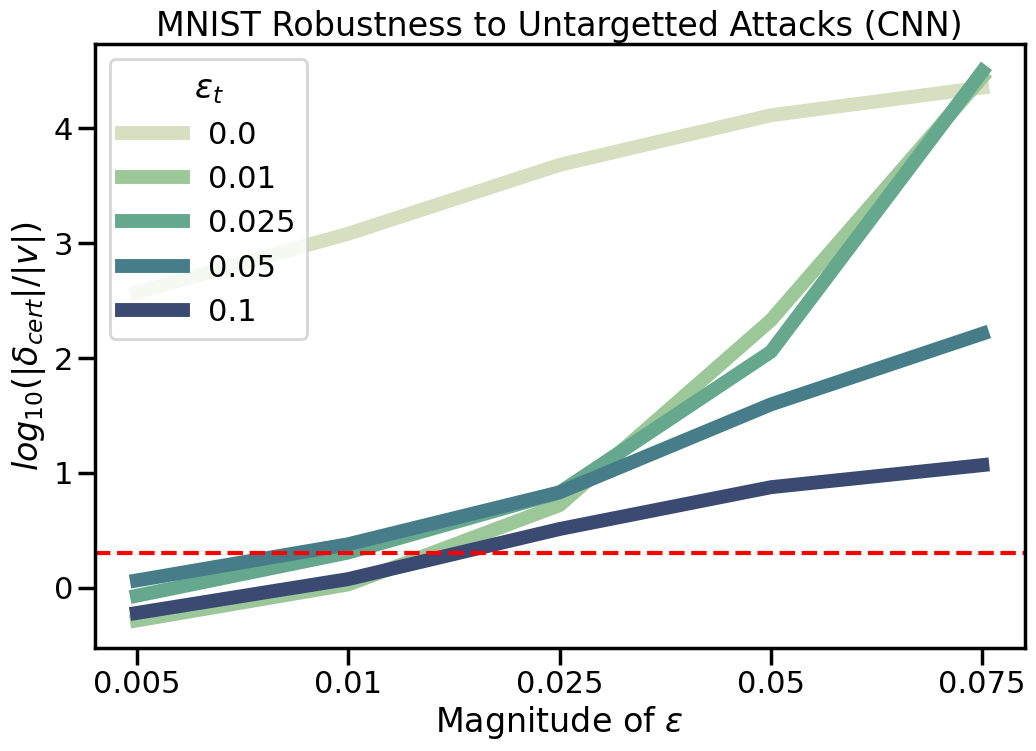

In [18]:
print(delta_vals)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('darkgrid')
sns.set_context('poster')
plt.figure(figsize=(12, 8), dpi=100)

pal = sns.cubehelix_palette(start=.5, rot=-.75)
print(pal.as_hex())

for i in range(len(eps_vals)):
    plt.plot(np.log10(delta_vals[i]), label=eps_vals[i], 
             color=pal[i], linewidth=10)
plt.legend()
ax = plt.gca()
ax.set_xticks(range(len(e_test_vals)))
ax.set_xticklabels(e_test_vals)
plt.title("%s Robustness to Untargetted Attacks (CNN)"%(dataset))
plt.ylabel(r"$log_{10}(|\delta_{cert}| / |v|)$")
plt.xlabel(r"Magnitude of $\epsilon$")
plt.axhline(y=0.3, color='r', linestyle='--')
#plt.y
ax.get_legend().set_title(r"$\epsilon_t$")
plt.show()

In [ ]:
import torch.nn.functional as F

def adv_attack(model, data, target, epsilon):
    # Accuracy counter
    #target = torch.nn.functional.one_hot(target, num_classes=10)
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)[None, :]
    
    #print(output, target)
    loss = F.nll_loss(output, target)
    
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    sign_data_grad = data_grad.sign()
    perturbed_data = data + epsilon*sign_data_grad
    perturbed_data = torch.clamp(perturbed_data, 0, 1)
    output = model(perturbed_data)
    return output

def get_robust_rate(eps_t, eps, n=100):
    M_ID = gen_model_id(eps_t, 0.0)
    model.load_state_dict(torch.load('SEED_Models/%s.pt'%(M_ID)))
    certified = 0
    for i in range(n):
        data = np.asarray(mnist_testset[i][0])/255.0
        data = torch.Tensor([data])
        target = torch.Tensor([mnist_testset[i][1]]).type(torch.LongTensor)
        #y_l = adv_attack(model, data, target, eps)
        y_l, y_u = GradCertModule.RobustnessBounds(model, data, target, eps=eps, gam=0.0)
        if(np.argmax(y_l.detach().numpy()) == mnist_testset[i][1]):
            certified += 1
    return certified/n


e_test_vals = [0.0, 0.02, 0.04, 0.06, 0.08, 0.10, 0.12]
eps_vals = [0.0, 0.01, 0.025, 0.05, 0.1]

rob_rates = []
for e_t in eps_vals:
    result = []
    for e in e_test_vals:
        val = get_robust_rate(e_t, e, n=1000)
        result.append(val)
    rob_rates.append(result)
    
#get_robust_rate(0.1, 0.1, n=100)

In [ ]:

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('darkgrid')
sns.set_context('poster')
plt.figure(figsize=(12, 8), dpi=100)

pal = sns.diverging_palette(250, 6, n=6)
pal = list(reversed(pal))

for i in range(len(eps_vals)):
    plt.plot(rob_rates[i], '-o', label=eps_vals[i], 
             color=pal[i], linewidth=10 )
plt.legend()
ax = plt.gca()
ax.set_xticks(range(len(e_test_vals)))
ax.set_xticklabels(e_test_vals)
plt.title("%s (CNN/Certified Predictions)"%(dataset))
plt.ylabel("Prediction Certified Robustness")
plt.xlabel(r"Magnitude of $\epsilon$")
ax.get_legend().set_title(r"$\epsilon_t$")
plt.show()


In [ ]:
#17 tensor(0.0376)
#30 tensor(0.0376)
#32 tensor(0.0370)
#44 tensor(0.0374)
#68 tensor(0.0369)
#87 tensor(0.0375)
#93 tensor(0.0371)
index = 30

M_ID = gen_model_id(0.05, 0.05)
model.load_state_dict(torch.load('SEED_Models/%s.pt'%(M_ID)))
data = np.asarray(mnist_testset[index][0])/255.0
data = torch.Tensor([data])

target = torch.Tensor([mnist_testset[index][1]]).type(torch.LongTensor)
grad = GradCertModule.InputGrad(model, torch.Tensor(data.detach().numpy().reshape(1,28,28)), target)

b_val, x_adv, grad_adv, targex, loss = run_mnist_attack(model, data, target = [24, 5], 
                                                epsilon=0.25, iterations=175, lr=0.01)
print(index, loss)



In [ ]:
sns.set_style('white')
sns.set_context('poster')
plt.imshow(data.detach().numpy().reshape(28,28), cmap='gray_r')
plt.axis('off')
plt.show()

plt.imshow(np.abs(grad.detach().numpy().reshape(28,28)).T, cmap='coolwarm')
#plt.imshow(grad.detach().numpy().reshape(28,28).T, cmap='coolwarm')
plt.axis('off')
plt.show()

plt.imshow(x_adv.detach().numpy().reshape(28,28), cmap='gray_r')
plt.axis('off')
plt.show()

plt.imshow(np.abs(grad_adv.detach().numpy().reshape(28,28)), cmap='coolwarm')
#plt.imshow(grad_adv.detach().numpy().reshape(28,28), cmap='coolwarm')
plt.axis('off')
plt.show()

plt.imshow(np.abs(targex.detach().numpy().reshape(28,28)), cmap='coolwarm')
#plt.imshow(grad_adv.detach().numpy().reshape(28,28), cmap='coolwarm')
plt.axis('off')
plt.show()

In [ ]:
#17 tensor(0.0376)
#30 tensor(0.0376)
#32 tensor(0.0370)
#44 tensor(0.0374)
#68 tensor(0.0369)
#87 tensor(0.0375)
#93 tensor(0.0371)
index = 30

M_ID = gen_model_id(0.05, 0.05)
model.load_state_dict(torch.load('SEED_Models/%s.pt'%(M_ID)))
data = np.asarray(mnist_testset[index][0])/255.0
data = torch.Tensor([data])

target = torch.Tensor([mnist_testset[index][1]]).type(torch.LongTensor)
grad = GradCertModule.InputGrad(model, torch.Tensor(data.detach().numpy().reshape(1,28,28)), target)

b_val, x_adv, grad_adv, targex = GradCertModule.run_model_attack(model, data, target = [24, 5], 
                                                gamma=0.25, iterations=175, lr=0.01)




In [ ]:
sns.set_style('white')
sns.set_context('poster')
plt.imshow(data.detach().numpy().reshape(28,28), cmap='gray_r')
plt.axis('off')
plt.show()

plt.imshow(np.abs(grad.detach().numpy().reshape(28,28)).T, cmap='coolwarm')
#plt.imshow(grad.detach().numpy().reshape(28,28).T, cmap='coolwarm')
plt.axis('off')
plt.show()

#plt.imshow(x_adv.detach().numpy().reshape(28,28), cmap='gray_r')
#plt.axis('off')
#plt.show()

plt.imshow(np.abs(grad_adv.detach().numpy().reshape(28,28)), cmap='coolwarm')
#plt.imshow(grad_adv.detach().numpy().reshape(28,28), cmap='coolwarm')
plt.axis('off')
plt.show()

plt.imshow(np.abs(targex.detach().numpy().reshape(28,28)), cmap='coolwarm')
#plt.imshow(grad_adv.detach().numpy().reshape(28,28), cmap='coolwarm')
plt.axis('off')
plt.show()